## Result of GAiA's neural network

In [1]:
from lib.dataset_utils import encode_position, read_many_hdf5
from lib.score_getter import ScoreGetter, Engine
from lib.torch_model_wrapper import TorchWrapper

import chess
import numpy as np
import matplotlib.pyplot as plt
import torch

import platform
if platform.system() == "Darwin":
  %config InlineBackend.figure_format="retina"  # For high DPI display

In [2]:
device = torch.device("cuda:0")

We retrieve the network trained in the `train_model` notebook.

In [3]:
twrapper = TorchWrapper(None, device, None, None)
twrapper.load("saved_models/GAiA_Network.pth")

In [4]:
def coefficient_determination(y_true, y_pred):
  nom = np.sum(np.square(y_true - y_pred))
  denom = np.sum(np.square(y_true - np.mean(y_true)))
  return 1 - nom / denom

def plot_regression_results(network, X_test, y_test, path=None):
  y_test = y_test.reshape(-1,1)
  preds = network.predict(X_test, batch_size=1024)
  r2_score = coefficient_determination(y_test, preds)
  ma = np.max(y_test)
  mi = np.min(y_test)
  x = np.linspace(ma, mi, 100)
  plt.figure(figsize=(10,5))
  plt.plot(x, x, "r-.", label = "Predictions = True values")
  plt.scatter(y_test, preds, label = f"$R^2 = {r2_score:.2f}$")

  mask1 = y_test < -5000
  mask2 = preds > -3000
  mask3 = y_test > 5000
  mask4 = preds < 3000
  mask = (mask1 & mask2) | (mask3 & mask4)
  mask1 = y_test > -2500
  mask2 = y_test < 2500
  mask3 = preds > 5000
  mask4 = preds < -5000
  mask = mask | ((mask1 & mask2) & (mask3 | mask4))


  plt.scatter(y_test[mask], preds[mask], color="orange", label = "Misplaced points")

  plt.xlabel("True values (centipawn)")
  plt.ylabel("Predictions (centipawn)")
  plt.title(f"Results of GAiA's neural network with {X_test.shape[0]} test positions")
  plt.legend()
  if path:
    plt.savefig(path)

We load our test dataset and we plot the results (finally).

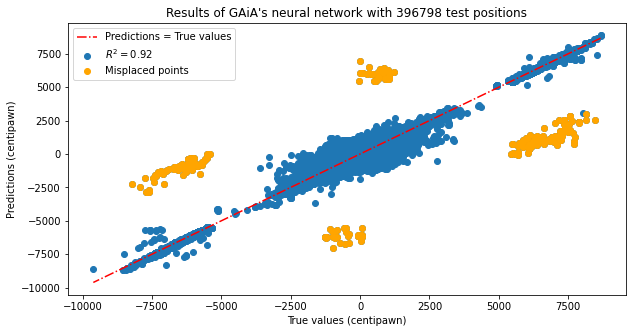

In [5]:
directory = "/media/gaetan/HDD/IA/Chess/Datasets/SE_ResNet/"
positions_test, scores_test = read_many_hdf5(396798, directory, "_test")
positions_test = positions_test.transpose((0, 3, 1, 2)) # Channel first
plot_regression_results(twrapper, positions_test, scores_test, path="results/result.pdf")

In [6]:
def test_position (network, engine_path, fen):
  score_getter = ScoreGetter(engine_path, Engine.STOCKFISH)

  print(fen)
  board = chess.Board(fen)
  e = np.expand_dims(encode_position(board), axis=0)
  e = e.transpose((0, 3, 1, 2))
  print(f"Score of Stockfish 14: {score_getter.get_score(fen)}")
  print(f"Score of GAiA: {int(network.predict(e).flatten()[0])}")

  return board

We observe the difference between GAiA and the Stockfish evaluation function on any chess position.

r1bqkb1r/pppp1ppp/2nn4/1B2N3/8/8/PPPP1PPP/RNBQR1K1 b kq - 0 6
Score of Stockfish 14: 67.0
Score of GAiA: 137


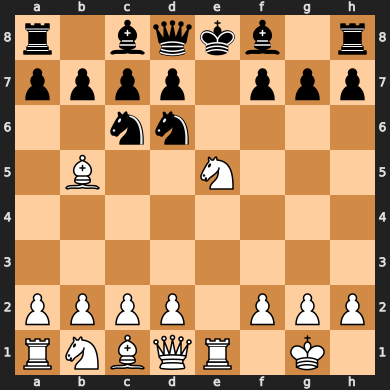

In [7]:
engine_path = "bin/stockfish"
test_position(twrapper, engine_path, "r1bqkb1r/pppp1ppp/2nn4/1B2N3/8/8/PPPP1PPP/RNBQR1K1 b kq - 0 6")

rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
Score of Stockfish 14: 31.0
Score of GAiA: 3


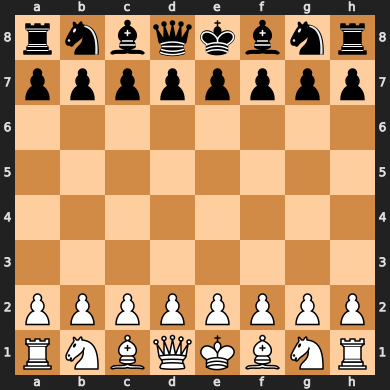

In [8]:
test_position(twrapper, engine_path, "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1")

8/4q3/5K2/8/4k3/8/8/8 w - - 0 1
Score of Stockfish 14: -55.0
Score of GAiA: -6097


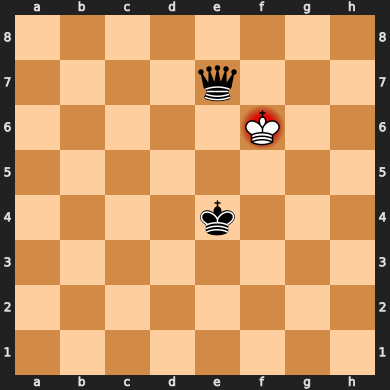

In [9]:
test_position(twrapper, engine_path, "8/4q3/5K2/8/4k3/8/8/8 w - - 0 1")

8/8/6P1/8/1K3Q2/4k3/8/8 b - - 0 1
Score of Stockfish 14: 863.0
Score of GAiA: 6120


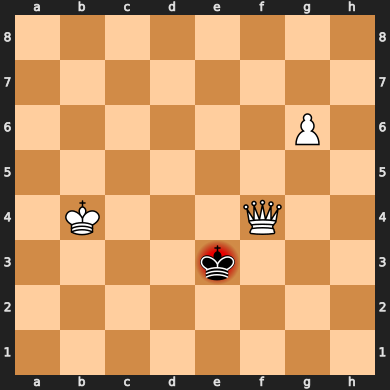

In [10]:
test_position(twrapper, engine_path, "8/8/6P1/8/1K3Q2/4k3/8/8 b - - 0 1")